In [2]:
import os

In [3]:
%pwd

'd:\\Kidney-Disease-Classification-DL-MLflow-DVC\\research'

In [4]:
os.chdir('../')

In [5]:
%pwd

'd:\\Kidney-Disease-Classification-DL-MLflow-DVC'

In [6]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/sujalvishwakarma/Kidney-Disease-Classification-DL-MLflow-DVC.mlflow"

In [6]:
import dagshub

dagshub.init(repo_owner='sujalvishwakarma', repo_name='Kidney-Disease-Classification-DL-MLflow-DVC', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

Accessing as sujalvishwakarma

Initialized MLflow to track repo "sujalvishwakarma/Kidney-Disease-Classification-DL-MLflow-DVC"

Repository sujalvishwakarma/Kidney-Disease-Classification-DL-MLflow-DVC initialized!

In [7]:
import tensorflow as tf

In [8]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

In [9]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int

In [10]:
from KidneydiseaseClassifier.constants import *
from KidneydiseaseClassifier.utils.common import read_yaml, create_directories, save_json

In [11]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_evaluation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/kidney-ct-scan-image",
            mlflow_uri="https://dagshub.com/sujalvishwakarma/Kidney-Disease-Classification-DL-MLflow-DVC.mlflow",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config

In [12]:
import tensorflow as tf
from pathlib import Path
import mlflow
import mlflow.keras
from urllib.parse import urlparse

In [13]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )


    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    
    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss": self.score[0], "accuracy": self.score[1]}
            )
            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.keras.log_model(self.model, "model", registered_model_name="VGG16Model")
            else:
                mlflow.keras.log_model(self.model, "model")

In [14]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    # evaluation.log_into_mlflow()

except Exception as e:
   raise e

[2025-04-11 02:56:48,305: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-11 02:56:48,317: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-11 02:56:48,319: INFO: common: created directory at: artifacts]


Found 139 images belonging to 2 classes.
9/9 [==============================] - 9s 929ms/step - loss: 0.0538 - accuracy: 0.9784
[2025-04-11 02:56:57,745: INFO: common: json file saved at: scores.json]


Found 93 images belonging to 2 classes.
3/3 [==============================] - 6s 2s/step


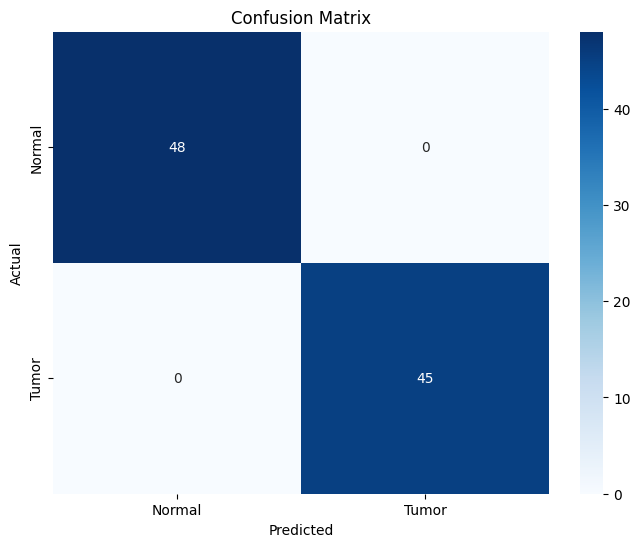

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        48
       Tumor       1.00      1.00      1.00        45

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



In [15]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Path to the trained model
model_path = os.path.join("artifacts", "training", "model.h5")
model = tf.keras.models.load_model(model_path)

# Set up image generator for validation data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    directory="artifacts/data_ingestion/kidney-ct-scan-image",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# Predicting
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(val_generator.class_indices.keys())

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=labels)
print(report)


In [16]:
print(np.unique(y_true, return_counts=True))

(array([0, 1]), array([48, 45], dtype=int64))


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
print(val_generator.class_indices)


{'Normal': 0, 'Tumor': 1}


In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = "path_to_your_test_image.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print("Raw prediction:", prediction)
print("Class:", list(val_generator.class_indices.keys())[np.argmax(prediction)])

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_test_image.jpg'